In [1]:
import json
import pandas as pd
import pickle

In [2]:
with open('runs/models/summary.pk', 'rb') as f:
    summary = pickle.load(f)

In [3]:
summary['model_11']

{'rewards': {'random': 0.5623922460053068,
  'baseline': 0.5748980923835975,
  'rl': 0.6830969052665726},
 'episode': 5900,
 'target': {'train': 0.7614248866698287, 'val': 0.7598680433208965}}

In [4]:
from framework import *
from joblib import Parallel, delayed
import torch

data_dir = './job_data'
features_path = f'{data_dir}/features.csv'
clf_path =  f'{data_dir}/classifiers.pkl'
settings_path = f'{data_dir}/settings8.json'
reward_path = f'{data_dir}/exhaustive.csv'
splits_path = f'{data_dir}/splits.pk'
model_path = 'runs/models/model_11.bin'

setup = SetUp(features_path, clf_path, splits_path, settings_path, reward_path)
rl_args = setup.rl_kwargs()
rl_args['model_path'] = model_path
rl_eval = RLEval(**rl_args)

100%|██████████| 1000/1000 [00:47<00:00, 20.97it/s]


In [5]:
cases_rl, rewards_rl, paths_rl = rl_eval.get_rewards(set_key='test', strategy_key='rl', full_path=True)
cases_baseline, rewards_baseline, paths_baseline = rl_eval.get_rewards(set_key='test', strategy_key='baseline', full_path=True)
cases_random, rewards_random, paths_random = rl_eval.get_rewards(set_key='test', strategy_key='random', full_path=True)
cases_photo, rewards_photo, paths_photo = rl_eval.get_rewards(set_key='test', strategy_key='photo', full_path=True)
cases_photo_spec, rewards_photo_spec, paths_photo_spec = rl_eval.get_rewards(set_key='test', strategy_key='photo_spec', full_path=True)
cases_photo_color, rewards_photo_color, paths_photo_color = rl_eval.get_rewards(set_key='test', strategy_key='photo_color', full_path=True)
cases_full, rewards_full, paths_full = rl_eval.get_rewards(set_key='test', strategy_key='full', full_path=True)

There is no experience in memory similar to                    case with id:1200975110544090880 and settings:(14, 0, 0)
There is no experience in memory similar to                    case with id:1200975110544090880 and settings:(14, 0, 0)
There is no experience in memory similar to                    case with id:1200975110544090880 and settings:(14, 0, 0)
There is no experience in memory similar to                    case with id:1200975110544090880 and settings:(14, 0, 0)


In [6]:
from trees import CaseNode

def cases_strategy(setup, rl_eval, n_spec, n_color, n_obs):
    
    assert n_obs in [0,1]
    
    case_settings = setup.env.case_settings.copy()
    cases_photo = []
    for i, ftrs in rl_eval.test_ftrs.iterrows():
        case_settings['n_spec'] = n_spec
        case_settings['n_color'] = n_color
        case_settings['n_obs'] = ftrs.lengths_gaia*n_obs
        case_settings['all_features'] = ftrs
        case_i = CaseNode(**case_settings)
        cases_photo.append(case_i)
    
    return cases_photo

cases_photo = cases_strategy(setup, rl_eval, n_spec=0, n_color=0, n_obs=1)
cases_photo_color = cases_strategy(setup, rl_eval, n_spec=0, n_color=1, n_obs=1)
cases_photo_spec = cases_strategy(setup, rl_eval, n_spec=1, n_color=0, n_obs=1)
cases_full = cases_strategy(setup, rl_eval, n_spec=1, n_color=1, n_obs=1)

In [7]:
from sklearn.metrics import classification_report

y_true_rl = [c.label for c in cases_rl]
y_hat_rl = [c.prediction for c in cases_rl]
report_rl = classification_report(y_true_rl, y_hat_rl, output_dict=True)

y_true_baseline = [c.label for c in cases_baseline]
y_hat_baseline = [c.prediction for c in cases_baseline]
report_baseline = classification_report(y_true_baseline, y_hat_baseline, output_dict=True)

y_true_random = [c.label for c in cases_random]
y_hat_random = [c.prediction for c in cases_random]
report_random = classification_report(y_true_random, y_hat_random, output_dict=True)

y_true_photo = [c.label for c in cases_photo]
y_hat_photo = [c.prediction for c in cases_photo]
report_photo = classification_report(y_true_photo, y_hat_photo, output_dict=True)

y_true_photo_color = [c.label for c in cases_photo_color]
y_hat_photo_color = [c.prediction for c in cases_photo_color]
report_photo_color = classification_report(y_true_photo_color, y_hat_photo_color, output_dict=True)

y_true_photo_spec = [c.label for c in cases_photo_spec]
y_hat_photo_spec = [c.prediction for c in cases_photo_spec]
report_photo_spec = classification_report(y_true_photo_spec, y_hat_photo_spec, output_dict=True)

y_true_full = [c.label for c in cases_full]
y_hat_full = [c.prediction for c in cases_full]
report_full = classification_report(y_true_full, y_hat_full, output_dict=True)

In [8]:
report_rl['accuracy']

0.9316037735849056

In [9]:
n_obs_rl = np.mean([c.n_obs for c in cases_rl])
n_obs_baseline = np.mean([c.n_obs for c in cases_baseline])
n_obs_random = np.mean([c.n_obs for c in cases_random])
n_obs_photo = np.mean([c.n_obs for c in cases_photo])
n_obs_photo_color = np.mean([c.n_obs for c in cases_photo_color])
n_obs_photo_spec = np.mean([c.n_obs for c in cases_photo_spec])
n_obs_full = np.mean([c.n_obs for c in cases_full])

In [10]:
n_spec_rl = np.mean([c.n_spec for c in cases_rl])
n_spec_baseline = np.mean([c.n_spec for c in cases_baseline])
n_spec_random = np.mean([c.n_spec for c in cases_random])
n_spec_photo = np.mean([c.n_spec for c in cases_photo])
n_spec_photo_color = np.mean([c.n_spec for c in cases_photo_color])
n_spec_photo_spec = np.mean([c.n_spec for c in cases_photo_spec])
n_spec_full = np.mean([c.n_spec for c in cases_full])

In [11]:
n_color_rl = np.mean([c.n_color for c in cases_rl])
n_color_baseline = np.mean([c.n_color for c in cases_baseline])
n_color_random = np.mean([c.n_color for c in cases_random])
n_color_photo = np.mean([c.n_color for c in cases_photo])
n_color_photo_color = np.mean([c.n_color for c in cases_photo_color])
n_color_photo_spec = np.mean([c.n_color for c in cases_photo_spec])
n_color_full = np.mean([c.n_color for c in cases_full])

In [12]:
reward_rl = np.mean([c.reward for c in cases_rl])
reward_baseline = np.mean([c.reward for c in cases_baseline])
reward_random = np.mean([c.reward for c in cases_random])
reward_photo = np.mean([c.reward for c in cases_photo])
reward_photo_color = np.mean([c.reward for c in cases_photo_color])
reward_photo_color = np.mean([c.reward for c in cases_photo_color])
reward_full = np.mean([c.reward for c in cases_full])

In [13]:
test_ids = [c.survey_id for c in cases_rl]

exhaustive_path = '../costs/exhaustive.csv'
exhaustive_df = pd.read_csv(exhaustive_path)
exhaustive_test = exhaustive_df.set_index('gaia_id').loc[test_ids]

In [14]:
y_true_exhaustive = exhaustive_test.label
y_hat_exhaustive = exhaustive_test.prediction
report_exhaustive = classification_report(y_true_exhaustive, y_hat_exhaustive, output_dict=True)
n_obs_exhaustive = np.mean(exhaustive_test.photo)
n_spec_exhaustive = np.mean(exhaustive_test.spectrum)
n_color_exhaustive = np.mean(exhaustive_test.color) 
reward_exhaustive = np.mean(exhaustive_test.reward)

In [15]:
strategies = [
    'rl',
    'baseline',
    'random',
    'photo',
    'photo_color',
    'photo_spec',
    'full',
    'exhaustive'
]

accuracies = [
    report_rl['accuracy'],
    report_baseline['accuracy'],
    report_random['accuracy'],
    report_photo['accuracy'],
    report_photo_color['accuracy'],
    report_photo_spec['accuracy'],
    report_full['accuracy'],
    report_exhaustive['accuracy']
]

DSCT_f1_score = [
    report_rl['DSCT_SXPHE']['f1-score'],
    report_baseline['DSCT_SXPHE']['f1-score'],
    report_random['DSCT_SXPHE']['f1-score'],
    report_photo['DSCT_SXPHE']['f1-score'],
    report_photo_color['DSCT_SXPHE']['f1-score'],
    report_photo_spec['DSCT_SXPHE']['f1-score'],
    report_full['DSCT_SXPHE']['f1-score'],
    report_exhaustive['DSCT_SXPHE']['f1-score']
]

RRAB_f1_score = [
    report_rl['RRAB']['f1-score'],
    report_baseline['RRAB']['f1-score'],
    report_random['RRAB']['f1-score'],
    report_photo['RRAB']['f1-score'],
    report_photo_color['RRAB']['f1-score'],
    report_photo_spec['RRAB']['f1-score'],
    report_full['RRAB']['f1-score'],
    report_exhaustive['RRAB']['f1-score'],
]

RRC_f1_score = [
    report_rl['RRC']['f1-score'],
    report_baseline['RRC']['f1-score'],
    report_random['RRC']['f1-score'],
    report_photo['RRC']['f1-score'],
    report_photo_color['RRC']['f1-score'],
    report_photo_spec['RRC']['f1-score'],
    report_full['RRC']['f1-score'],
    report_exhaustive['RRC']['f1-score'],
]

n_obs = [
    n_obs_rl,
    n_obs_baseline,
    n_obs_random,
    n_obs_photo,
    n_obs_photo_color,
    n_obs_photo_spec,
    n_obs_full,
    n_obs_exhaustive
]

n_spec = [
    n_spec_rl,
    n_spec_baseline,
    n_spec_random,
    n_spec_photo,
    n_spec_photo_color,
    n_spec_photo_spec,
    n_spec_full,
    n_spec_exhaustive
]

n_color = [
    n_color_rl,
    n_color_baseline,
    n_color_random,
    n_color_photo,
    n_color_photo_color,
    n_color_photo_spec,
    n_color_full,
    n_color_exhaustive
]

reward = [
    reward_rl,
    reward_baseline,
    reward_random,
    reward_photo,
    reward_photo_color,
    reward_photo_color,
    reward_full,
    reward_exhaustive
]

results = {'strategies':strategies, 'accuracy': accuracies, 
           'DSCT_f1_score':DSCT_f1_score,
           'RRAB_f1_score':RRAB_f1_score,
           'RRC_f1_score':RRC_f1_score,
           'n_photo': n_obs, 'n_spec':n_spec,'n_color': n_color, 'reward':reward}

In [16]:
results = pd.DataFrame(results)

In [78]:
results.round(3)

,strategies,accuracy,DSCT_f1_score,RRAB_f1_score,RRC_f1_score,n_photo,n_spec,n_color,reward
0,rl,0.932,0.817,0.968,0.884,6.034,0.001,0.548,0.697
1,baseline,0.893,0.817,0.935,0.818,5.861,0.515,0.528,0.578
2,random,0.886,0.757,0.935,0.816,6.671,0.501,0.504,0.566
3,photo,0.902,0.795,0.936,0.862,13.320,0.000,0.000,0.504
4,photo_color,0.934,0.815,0.969,0.891,13.320,0.000,1.000,0.527
5,photo_spec,0.922,0.852,0.953,0.871,13.320,1.000,0.000,0.527
6,full,0.948,0.859,0.977,0.909,13.320,1.000,1.000,0.397
7,exhaustive,0.987,0.953,0.995,0.980,6.121,0.033,0.511,0.772


In [18]:
max_idx = np.argsort(rewards_rl)[::-1]

In [19]:
import matplotlib.pyplot as plt

In [708]:
from matplotlib.lines import Line2D
plt.rc('text', usetex=False)

def get_sources(path):
    node_0 = path[0]
    sources_add = [None]
    sources_keys = list(node_0.settings)
    sources_curr = np.array(list(node_0.settings.values()))
    j = 0
    for node in path[1:]:
        sources_next = np.array(list(node.settings.values()))
        diff_idx = np.where(sources_next-sources_curr)[0]
        if len(diff_idx)==0:
            break
        sources_add.append(sources_keys[diff_idx[0]])
        sources_curr = sources_next
        j +=1
    return np.array(sources_add)

def plot_strategies(path_rl, path_photo, path_full, ax):
#     fig, ax = plt.subplots(figsize=(8,4), dpi=200)
    
    plot_path(path_rl, ax, color='r', linestyle='-.')
    plot_path(path_photo, ax, color='b', linestyle='--')
    plot_path(path_full, ax, color='g', linestyle=':')
    
    ax.set_xlabel('Cost')
    ax.set_ylabel('Ground class probability')

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xrange = xmax-xmin
    yrange = ymax-ymin
    ax.set_xticks(np.arange(int(xmin), int(xmax)+1))
    ax.set_ylim(ymin-yrange*0.1, ymax+yrange*0.1)
    ax.set_xlim(xmin-xrange*0.01, xmax+xrange*0.01)
    ax.grid(linestyle='--')
    
    label = path_rl[0].label
    id_ = path_rl[0].survey_id
    ax.set_title(f'Observations Path for {label}')#'\n ID: {str(id_)}')
    
#     args = {'color':'w', 'markerfacecolor':'k', 'markersize':10}
#     legend_elements = [Line2D([0], [0], marker='d', label='+1 photometric obs.', **args),
#                        Line2D([0], [0], marker='s', label='+1 color obs.', **args),
#                        Line2D([0], [0], marker='^', label='+1 spectrum obs.', **args),
#                       ]
#     legend1 = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.34, -0.02))
    
#     args = {}
#     legend_elements = [Line2D([0], [0], linestyle='-.', color='r', label='RL strategy', **args),
#                        Line2D([0], [0], linestyle='--', color='b', label='Photo strategy', **args),
#                        Line2D([0], [0], linestyle=':', color='g', label='Full strategy', **args)
#                       ]
#     legend2 = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1.275, 0.24))
    
#     ax.add_artist(legend1)
#     ax.add_artist(legend2)
    
#     plt.show()
    
    id_txt = f'ID: {str(id_)}'
    ax.annotate(id_txt, xy=(0.97, 0.05), xycoords='axes fraction',
            size=7, ha='right', va='bottom',
            bbox=dict(boxstyle='square', fc='w', lw=0.5))

    xticks = ax.xaxis.get_ticklabels()
    if len(xticks)>8:
        for index, label in enumerate(xticks):
            if index % 2 != 0:
                label.set_visible(False)
    

def plot_path(path, ax, color='r', linestyle='--'):
    x = np.array([node.cost for node in path])
    y = np.array([node.label_prob for node in path])
    if (x[-2]==x[-1]) & (y[-2]==y[-1]):
        x = x[:-1]
        y = y[:-1]
    sources = get_sources(path)
    sources_txt = [f'+{source}' for source in sources]

    x0 = x[:-1]
    x1 = x[1:]
    y0 = y[:-1]
    y1 = y[1:]
    xpos = (x0+x1)/2
    ypos = (y0+y1)/2
    xdir = x1-x0
    ydir = y1-y0

#     for X,Y,dX,dY in zip(xpos, ypos, xdir, ydir):
#         ax.annotate("", xytext=(X,Y), xy=(X+0.001*dX,Y+0.001*dY), size=7,
#                     arrowprops=dict(arrowstyle="-|>", color=color))#, alpha=0.5))

    y_delta = np.random.uniform(0.0, 0.05)
#     for x_,y_,name in zip(x[1:], y[1:], sources_txt):
#         ax.annotate(name, (x_-0.15, y_+y_delta), size=8, color=color)
    
    
    ax.plot(x, y, linestyle=linestyle, linewidth=0.9, color=color, zorder=1)#, alpha=0.5)
    ax.scatter(x[sources=='photo'], y[sources=='photo'], color=color, zorder=2, marker='d', s=18)
    ax.scatter(x[sources=='color'], y[sources=='color'], color=color, zorder=2, marker='s', s=18)
    ax.scatter(x[sources=='spectrum'], y[sources=='spectrum'], color=color, zorder=2, marker='^', s=18)

def add_legend(ax):
    args = {'color':'w', 'markerfacecolor':'k', 'markersize':10}
    legend_elements = [Line2D([0], [0], marker='d', label='+1 photometric obs.', **args),
                       Line2D([0], [0], marker='s', label='+1 color obs.', **args),
                       Line2D([0], [0], marker='^', label='+1 spectrum obs.', **args),
                      ]
    legend1 = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(-0.12, -0.7))
    
    args = {}
    legend_elements = [Line2D([0], [0], linestyle='-.', color='r', label='RL strategy', **args),
                       Line2D([0], [0], linestyle='--', color='b', label='Photo strategy', **args),
                       Line2D([0], [0], linestyle=':', color='g', label='Full strategy', **args)
                      ]
    legend2 = plt.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.37, -0.7))
    
    ax.add_artist(legend1)
    ax.add_artist(legend2)

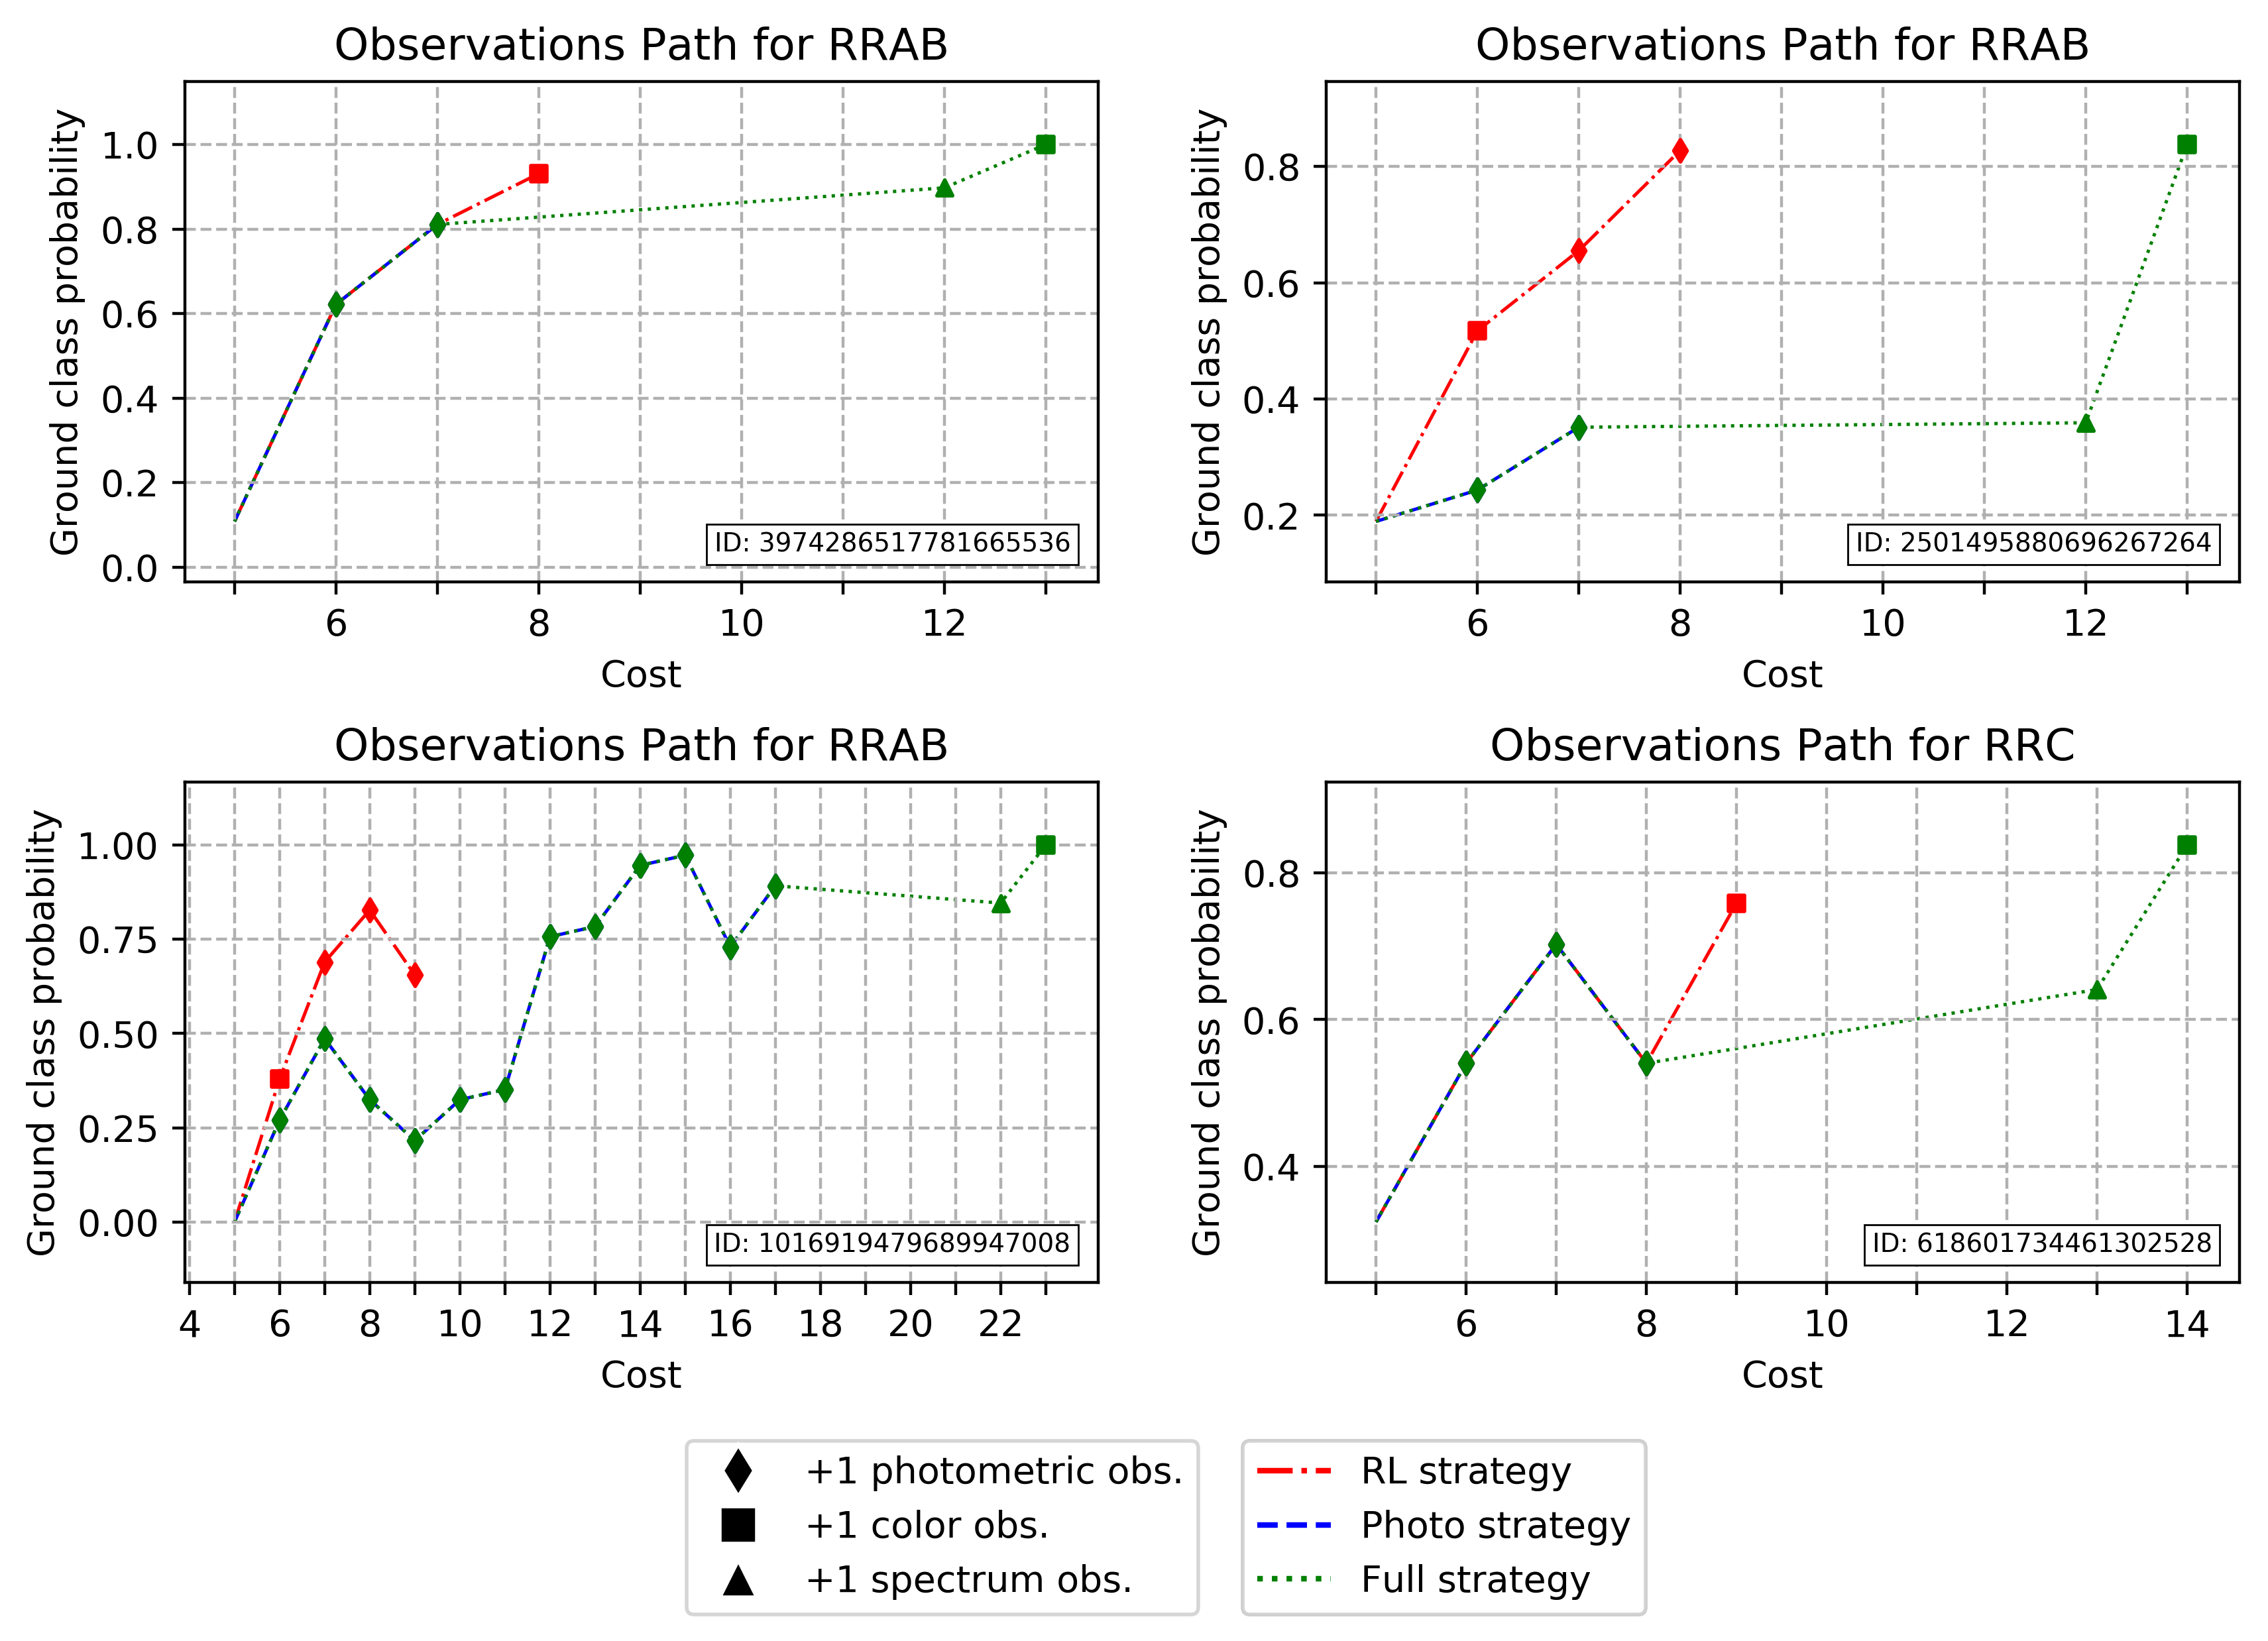

In [709]:
samples = [831, 327, 731, 521]

fig, axes = plt.subplots(2,2,figsize=(10,6), dpi=200)
axes = np.ndarray.flatten(axes)

for j in range(4):
    ax = axes[j]
    i = samples[j]
    path_rl_i = paths_rl[i]
    path_full_i = paths_full[i]
    path_photo_i = paths_photo[i]
    plot_strategies(path_rl_i, path_photo_i, path_full_i, ax)

add_legend(axes[-1])
plt.subplots_adjust(hspace=0.4, wspace=0.25)
plt.savefig('plots/samples.png', bbox_inches="tight")

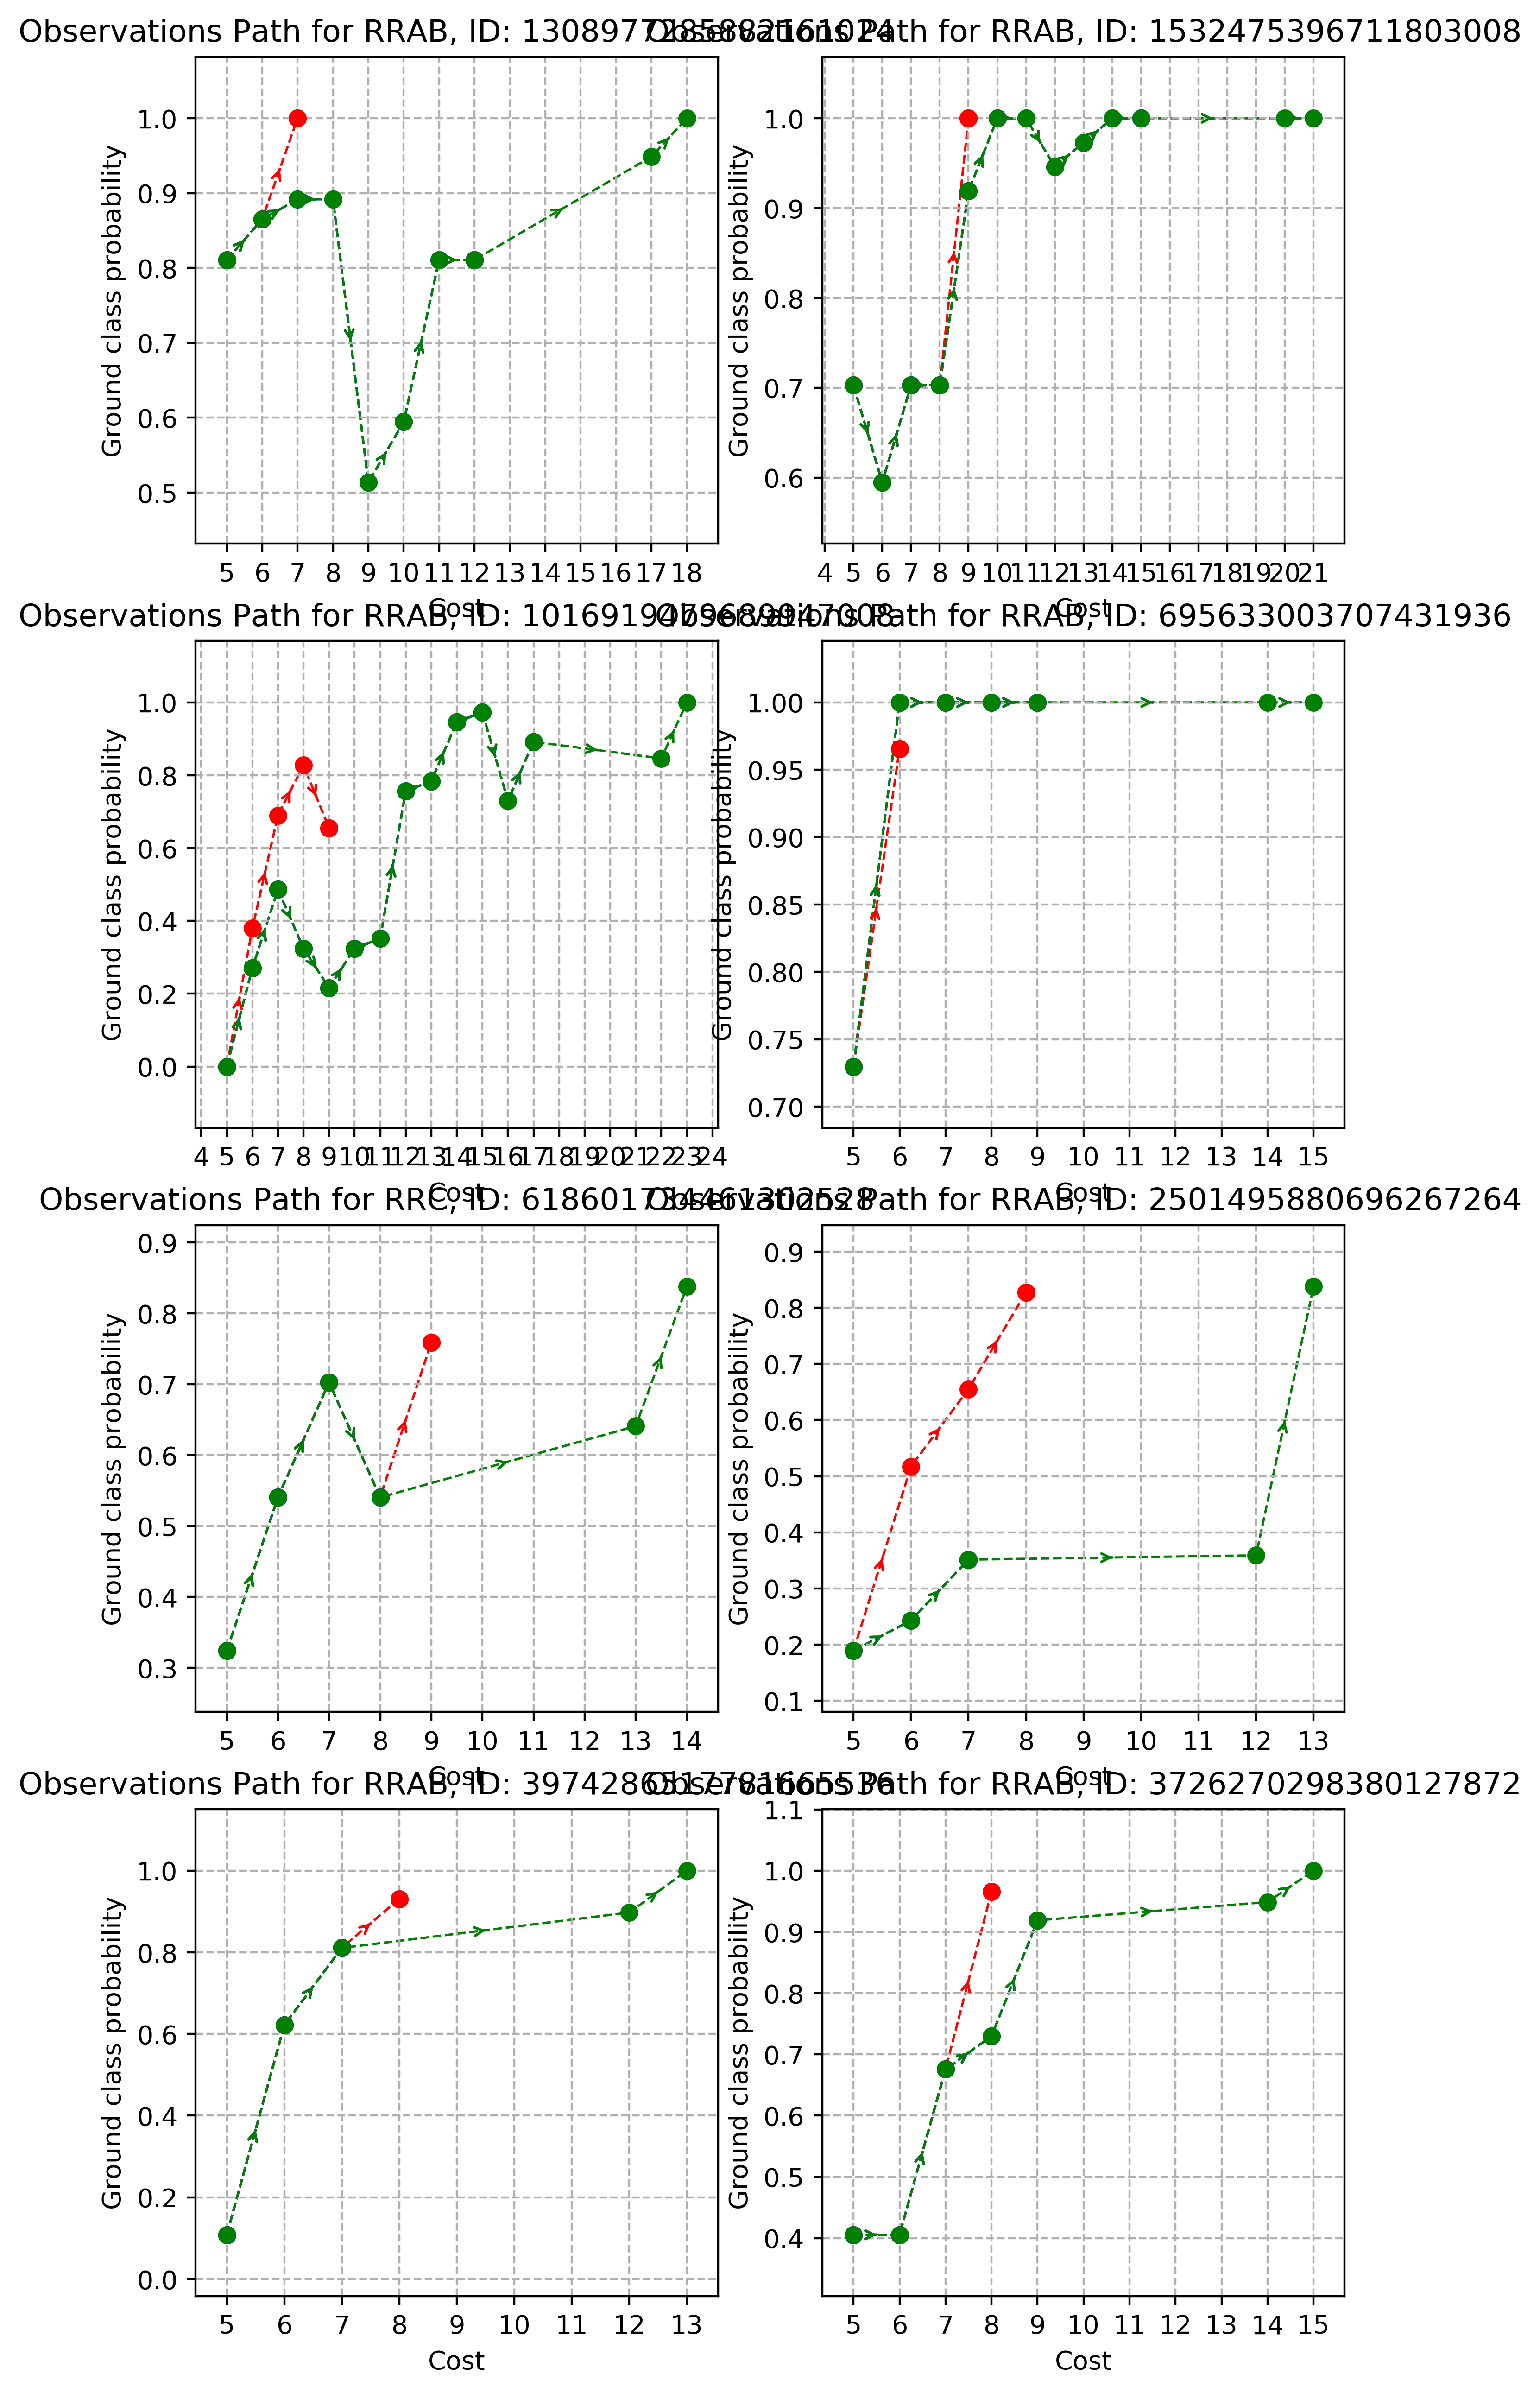

In [129]:
good_cases = [387, 101, 731, 365, 521, 327, 831, 375, 450, 831]

fig, axes = plt.subplots(4,2,figsize=(8,16), dpi=200)
axes = np.ndarray.flatten(axes)


for i in range(8):
    ax = axes[i]
    i = good_cases[i]
    path_rl_i = paths_rl[i]
    path_full_i = paths_full[i]
    path_photo_i = paths_photo[i]
    plot_strategies(path_rl_i, path_photo_i, path_full_i, ax)

In [68]:
data_rl = [(c.n_obs, c.n_color, c.n_spec, c.label_prob, c.reward) for c in cases_rl]
data_photo = [(c.n_obs, c.n_color, c.n_spec, c.label_prob, c.reward) for c in cases_photo]
data_full = [(c.n_obs, c.n_color, c.n_spec, c.label_prob, c.reward) for c in cases_full]
obs_rl, color_rl, spec_rl, label_prob_rl, reward_rl = list(zip(*data_rl))
obs_photo, color_photo, spec_photo, label_prob_photo, reward_photo = list(zip(*data_photo))
obs_full, color_full, spec_full, label_prob_full, reward_full = list(zip(*data_full))

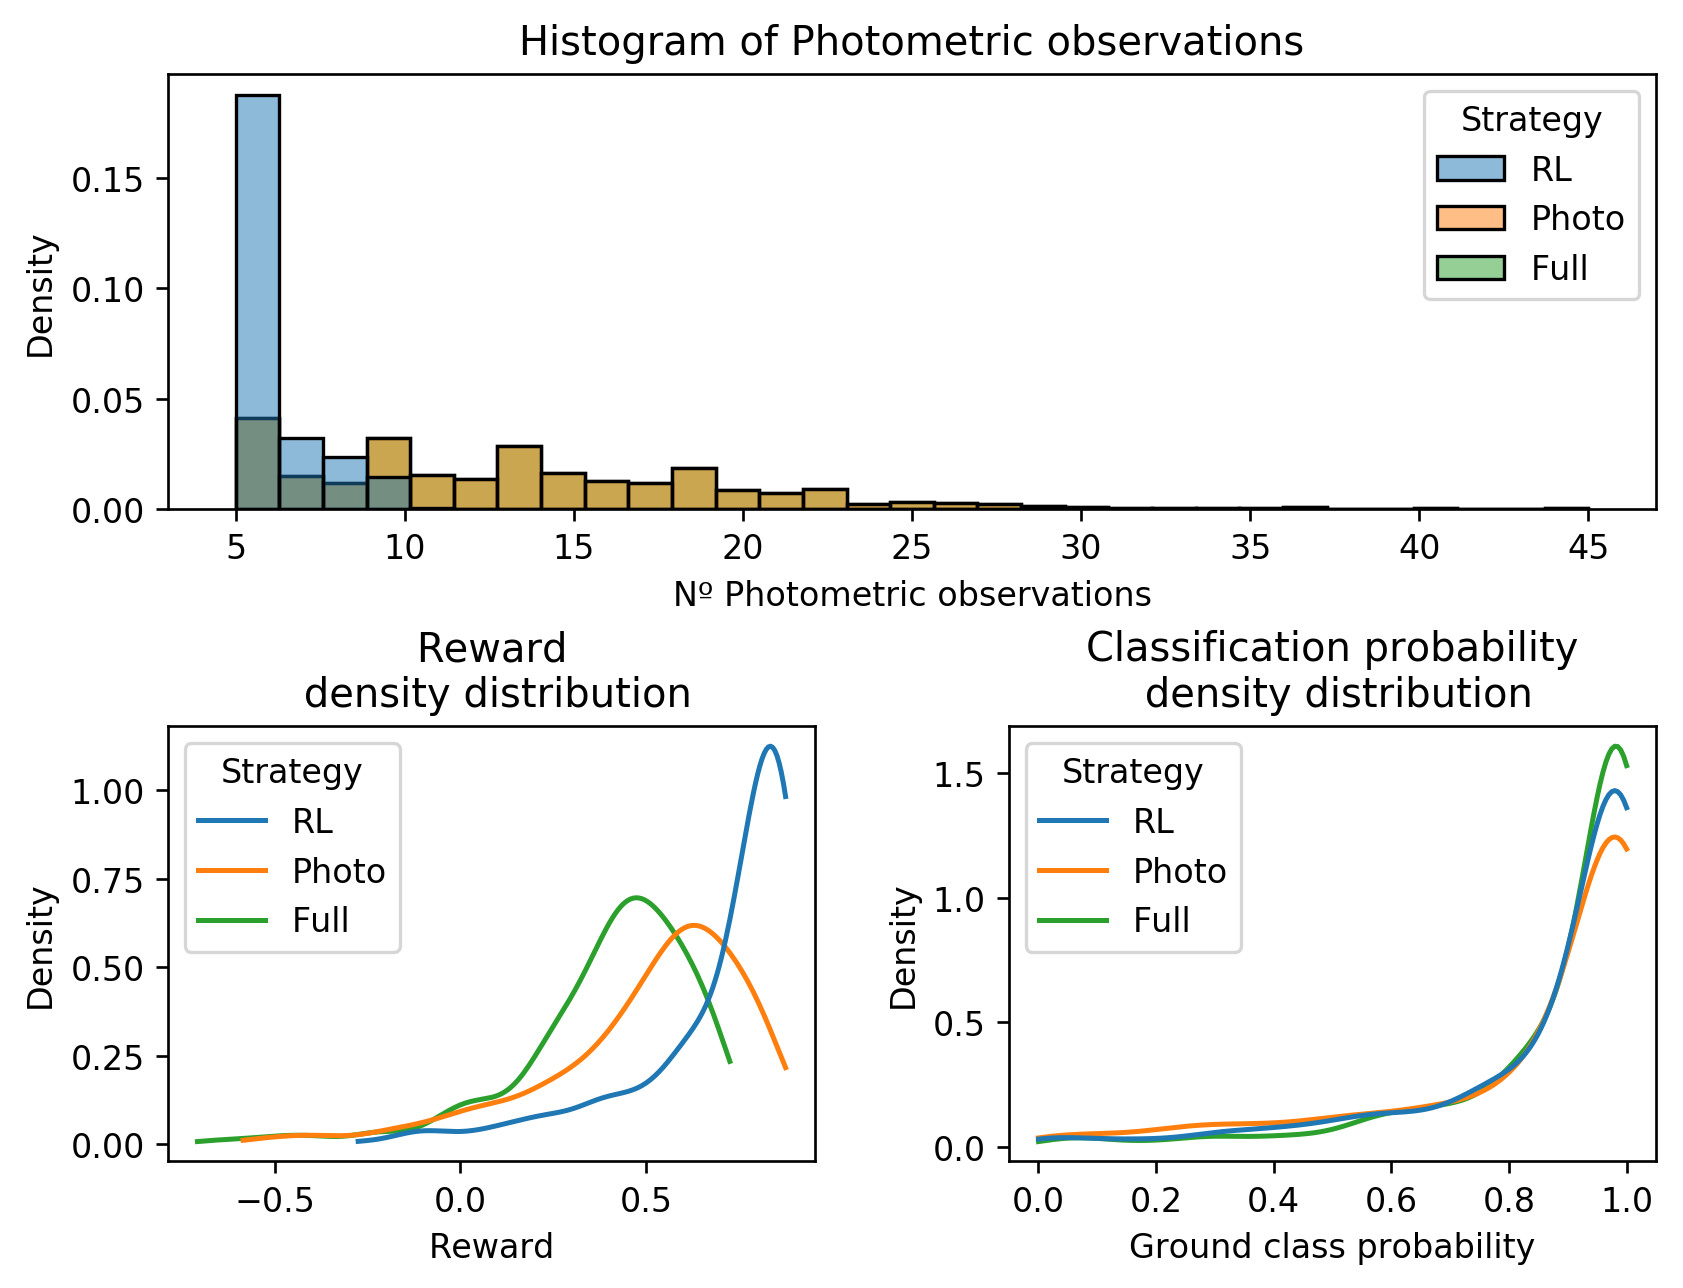

In [649]:
from matplotlib import gridspec

# fig, axes = plt.subplots(2,2, figsize=(5,5), dpi=120)
fig = plt.figure(figsize=(8, 6), dpi=120)
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[1,0])
ax1 = plt.subplot(gs[1,1])
ax2 = plt.subplot(gs[0,0:2])
sns.kdeplot(x=data_plot['Reward'], hue=data_plot['Strategy'], ax=ax0, cut=0)
sns.kdeplot(x=data_plot['Probability'], hue=data_plot['Strategy'], ax=ax1, cut=0)
sns.histplot(data=data_plot, x='n_obs', hue='Strategy', ax=ax2, stat='density')
ax2.set_xlabel('Nº Photometric observations')
ax2.set_title('Histogram of Photometric observations')
ax1.set_title('Classification probability\n density distribution')
ax1.set_xlabel('Ground class probability')
ax0.set_title('Reward\n density distribution')
# g.legend_._set_loc(0)
# g.legend_.set_bbox_to_anchor((2.85,0.58))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig('plots/densities.png')

In [25]:
import seaborn as sns

In [514]:
test_n = len(cases_rl)

prob_data = np.hstack([label_prob_rl, label_prob_photo, label_prob_full])
obs_data = np.hstack([obs_rl, obs_photo, obs_full]).astype(int)
reward_data = np.hstack([reward_rl, reward_photo, reward_full])
spec_data = np.hstack([spec_rl, spec_photo, spec_full])
color_data = np.hstack([color_rl, color_photo, color_full])
labels = ['RL']*test_n+['Photo']*test_n+['Full']*test_n
data_plot = pd.DataFrame({'Probability':prob_data, 'n_obs':obs_data, 'Reward':reward_data, 'Strategy':labels,
                         'n_spec': spec_data, 'n_color': color_data})